# <center> Assignment 6 – Supercomputers and Parallel AI Training (10/25/22)
# <center> Submitted By: Haridas Das

# Problem 1
If learning rate is too large code can not get gpod accuracy at the begging. 

Homework (Modifying the code tensorflow2_mnist.py in the homework file)
Scaling MNIST example
The goal of this homework is to modify a sequential mnist code into a data parallel code with Horovod and test the scaling efficiency

•	50%: Modify the ./homework/tensorflow2_mnist.py to Horovod (save it as "./homework/tensorflow2_mnist_hvd.py"

•	25%: Run scaling test upto 16 nodes, and check the overall timing

    mpirun -n 1 python tensorflow2_mnist_hvd.py
    
    mpirun -n 2 python tensorflow2_mnist_hvd.py
    
    mpirun -n 4 python tensorflow2_mnist_hvd.py
    
    mpirun -n 8 python tensorflow2_mnist_hvd.py
    
    
•	25%: Plot the training accuracy and validation accuracy curve for different scales. (x-asix: epoch; y-axis: accuracy) Save your plots as pdf files in the ./homework folder "accuracy_1.pdf, accuracy_2.pdf, accuracy_4.pdf, accuracy_8.pdf"
Provide the link to your ./homework folder on your personal GitHub repo.

•	Bonus: The accuracy for large scale training can be improved by using smaller learning rate in the beginning few epochs (warmup epochs). Implement the warmup epochs


**Hints: We know train_resnet34 is sequential version, and train_resnet34_hvd is the Horovod version. First, take a look at the difference between them, then need to to modify the tensorflow2_mnist.py to tensorflow2_mnist_hvd.py. **

# Solution: 

qsub-gpu -I -n 1 -t 60 -A ALCFAITP -q full-node

We can get 8 GPUs even though we specified -n as 1 because the n in the qsub refers to the number of full-nodes and each full-node has 8 GPUs. 

# Comparison 

We will compare the results for the following chages, i.e. sharing nodes 

1. mpirun -n 1 python tensorflow2_mnist_hvd.py
2. mpirun -n 2 python tensorflow2_mnist_hvd.py
3. mpirun -n 4 python tensorflow2_mnist_hvd.py
4. mpirun -n 8 python tensorflow2_mnist_hvd.py

# code : tensorflow2_mnist_hvd.py

In [ ]:
# Copyright 2019 Uber Technologies, Inc. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

import tensorflow as tf
import argparse

import numpy as np
import matplotlib.pyplot as plt

import time
t0 = time.time()
parser = argparse.ArgumentParser(description='TensorFlow MNIST Example')
parser.add_argument('--batch_size', type=int, default=256, metavar='N',
                    help='input batch size for training (default: 256)')
parser.add_argument('--epochs', type=int, default=16, metavar='N',
                    help='number of epochs to train (default: 16)')
parser.add_argument('--lr', type=float, default=0.01, metavar='LR',
                    help='learning rate (default: 0.01)')
parser.add_argument('--device', default='gpu',
                    help='Wheter this is running on cpu or gpu')
parser.add_argument('--num_inter', default=2, help='set number inter', type=int)
parser.add_argument('--num_intra', default=0, help='set number intra', type=int)

args = parser.parse_args()


if args.device == 'cpu':
    tf.config.threading.set_intra_op_parallelism_threads(args.num_intra)
    tf.config.threading.set_inter_op_parallelism_threads(args.num_inter)
else:
    gpus = tf.config.experimental.list_physical_devices('GPU')
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)



#---------------------------------------------------
# Dataset
#---------------------------------------------------
(mnist_images, mnist_labels), (x_test, y_test) = \
    tf.keras.datasets.mnist.load_data(path='mnist.npz')

dataset = tf.data.Dataset.from_tensor_slices(
    (tf.cast(mnist_images[..., tf.newaxis] / 255.0, tf.float32),
             tf.cast(mnist_labels, tf.int64))
)
test_dset = tf.data.Dataset.from_tensor_slices(
    (tf.cast(x_test[..., tf.newaxis] / 255.0, tf.float32),
             tf.cast(y_test, tf.int64))
)

nsamples = len(list(dataset))
ntests = len(list(test_dset))

# shuffle the dataset, with shuffle buffer to be 10000
dataset = dataset.repeat().shuffle(10000).batch(args.batch_size)
test_dset  = test_dset.repeat().batch(args.batch_size)

#----------------------------------------------------
# Model
#----------------------------------------------------
mnist_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, [3, 3], activation='relu'),
    tf.keras.layers.Conv2D(64, [3, 3], activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])
loss = tf.losses.SparseCategoricalCrossentropy()

opt = tf.optimizers.Adam(args.lr)

checkpoint_dir = './checkpoints/tf2_mnist'
checkpoint = tf.train.Checkpoint(model=mnist_model, optimizer=opt)

#------------------------------------------------------------------
# Training
#------------------------------------------------------------------
@tf.function
def training_step(images, labels):
    with tf.GradientTape() as tape:
        probs = mnist_model(images, training=True)
        loss_value = loss(labels, probs)
        pred = tf.math.argmax(probs, axis=1)
        equality = tf.math.equal(pred, labels)
        accuracy = tf.math.reduce_mean(tf.cast(equality, tf.float32))

    grads = tape.gradient(loss_value, mnist_model.trainable_variables)
    opt.apply_gradients(zip(grads, mnist_model.trainable_variables))
    return loss_value, accuracy

@tf.function
def validation_step(images, labels):
    probs = mnist_model(images, training=False)
    pred = tf.math.argmax(probs, axis=1)
    equality = tf.math.equal(pred, labels)
    accuracy = tf.math.reduce_mean(tf.cast(equality, tf.float32))
    loss_value = loss(labels, probs)
    return loss_value, accuracy

from tqdm import tqdm 
t0 = time.time()
nstep = nsamples//args.batch_size
ntest_step = ntests//args.batch_size
metrics={}
metrics['train_acc'] = []
metrics['valid_acc'] = []
metrics['train_loss'] = []
metrics['valid_loss'] = []
metrics['time_per_epochs'] = []
for ep in range(args.epochs):
    training_loss = 0.0
    training_acc = 0.0
    tt0 = time.time()
    for batch, (images, labels) in enumerate(dataset.take(nstep)):
        loss_value, acc = training_step(images, labels)
        training_loss += loss_value/nstep
        training_acc += acc/nstep
        if batch % 100 == 0: 
            checkpoint.save(checkpoint_dir)
            print('Epoch - %d, step #%06d/%06d\tLoss: %.6f' % (ep, batch, nstep, loss_value))
    # Testing
    test_acc = 0.0
    test_loss = 0.0
    for batch, (images, labels) in enumerate(test_dset.take(ntest_step)):
        loss_value, acc = validation_step(images, labels)
        test_acc += acc/ntest_step
        test_loss += loss_value/ntest_step
    tt1 = time.time()
    print('E[%d], train Loss: %.6f, training Acc: %.3f, val loss: %.3f, val Acc: %.3f\t Time: %.3f seconds' % (ep, training_loss, training_acc, test_loss, test_acc, tt1 - tt0))
    metrics['train_acc'].append(training_acc.numpy())
    metrics['train_loss'].append(training_loss.numpy())
    metrics['valid_acc'].append(test_acc.numpy())
    metrics['valid_loss'].append(test_loss.numpy())
    metrics['time_per_epochs'].append(tt1 - tt0) 

    
checkpoint.save(checkpoint_dir)

import numpy as np
import matplotlib.pyplot as plt

#plt.rc('text', usetex=True)
plt.plot(range(args.epochs), metrics['train_acc'], 'r-o')
# naming the x axis
plt.xlabel('epocs')
# naming the y axis
plt.ylabel('train acc')
plt.title('train acc vs epochs')
plt.savefig("train_acc.png")
#plt.close()

#plt.rc('text', usetex=True)
plt.figure(figsize=(8, 8))
plt.plot(range(args.epochs), metrics['train_loss'], 'b-o')
# naming the x axis
plt.xlabel('epocs')
# naming the y axis
plt.ylabel('train loss')
plt.title('train loss vs epochs')
plt.savefig("train_loss.png")
#plt.close()

#plt.rc('text', usetex=True)
fig = plt.figure(figsize=(8, 8))
plt.plot(range(args.epochs), metrics['valid_acc'], 'g-o')
# naming the x axis
plt.xlabel('epocs')
# naming the y axis
plt.ylabel('valid acc')
plt.title('valid acc vs epochs')
plt.savefig("valid_acc.png") # or you can pass a Figure object to pdf.savefig
#plt.close()

#plt.rc('text', usetex=False)
fig = plt.figure(figsize=(8, 8))
plt.plot(range(args.epochs), metrics['valid_loss'], 'k-o')
# naming the x axis
plt.xlabel('epocs')
# naming the y axis
plt.ylabel('valid loss')
plt.title('valid_loss vs epochs')
plt.savefig("valid_loss.png") # or you can pass a Figure object to pdf.savefig
#plt.close()

#plt.rc('text', usetex=True)
plt.figure(figsize=(8, 8))
x = np.arange(0, 5, 0.1)
plt.plot(range(args.epochs), metrics['time_per_epochs'], 'b-o')
# naming the x axis
plt.xlabel('epocs')
# naming the y axis
plt.ylabel('time per epochs')
plt.title('time per epochs vs epochs')
plt.savefig("time_per_epochs.png")
#plt.close()
      

np.savetxt("metrics.dat", np.array([metrics['train_acc'], metrics['train_loss'], metrics['valid_acc'], metrics['valid_loss'], metrics['time_per_epochs']]).transpose())
t1 = time.time()
print("Total training time: %s seconds" %(t1 - t0))

# 1. mpirun -n 1 python tensorflow2_mnist_hvd.py

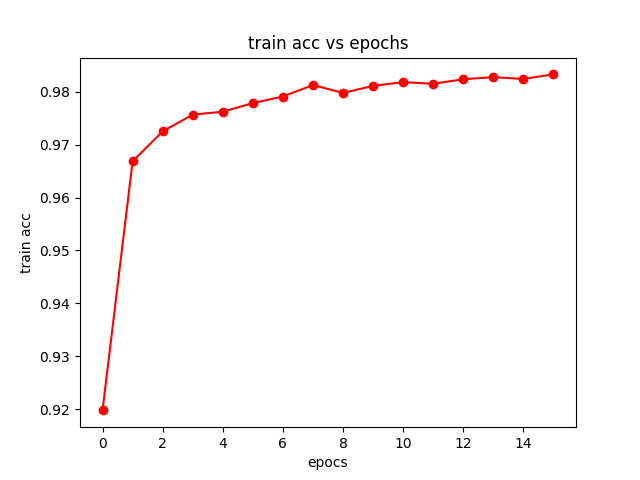

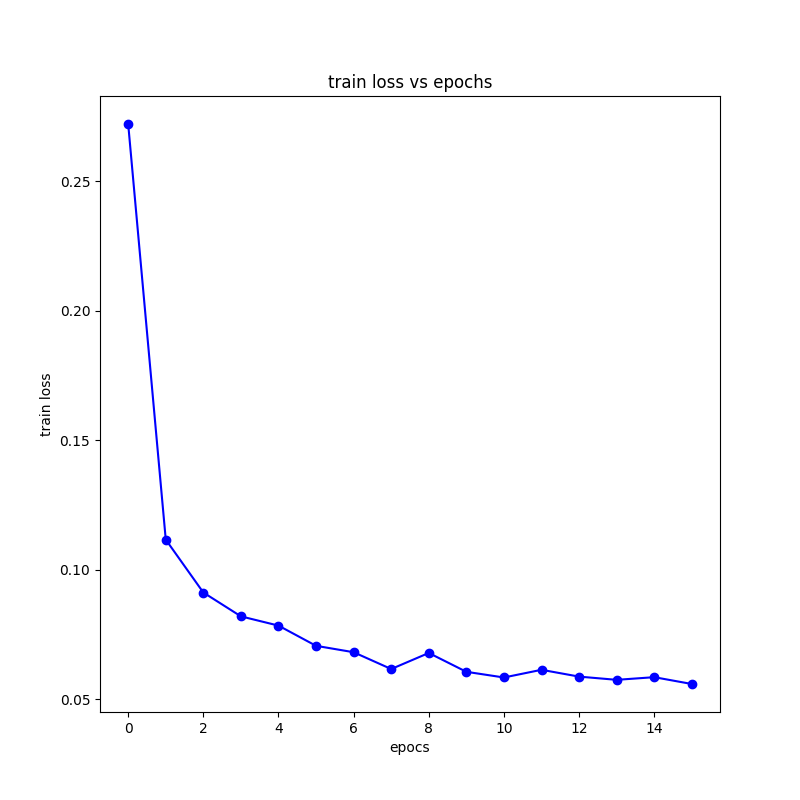

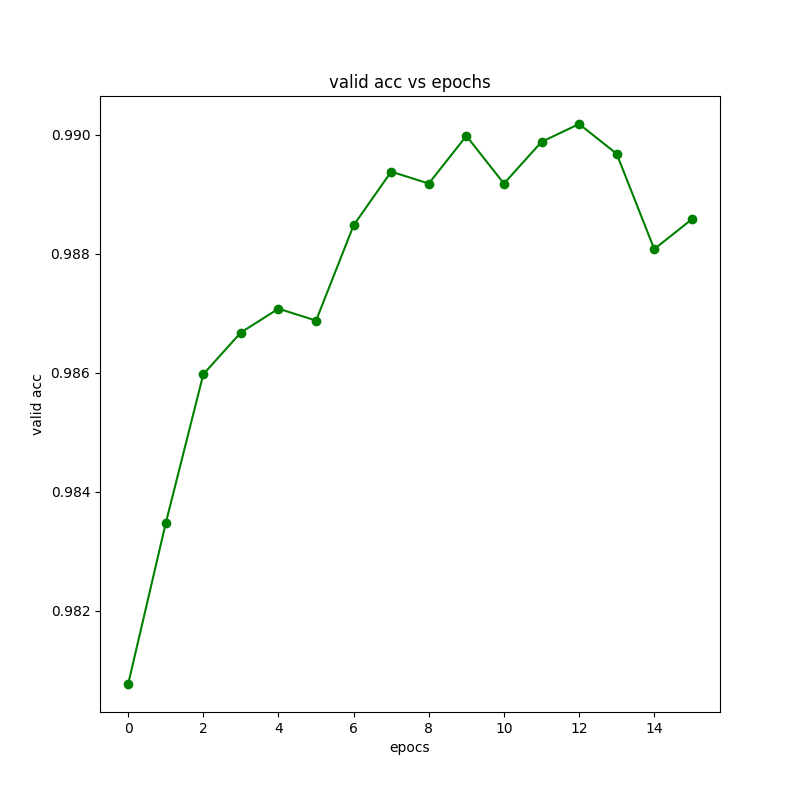

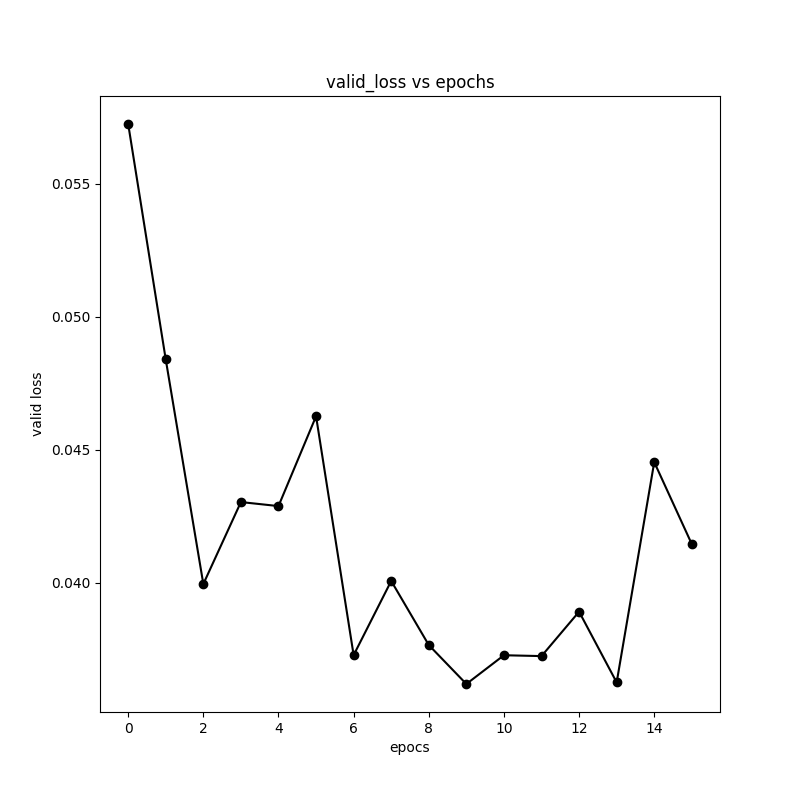

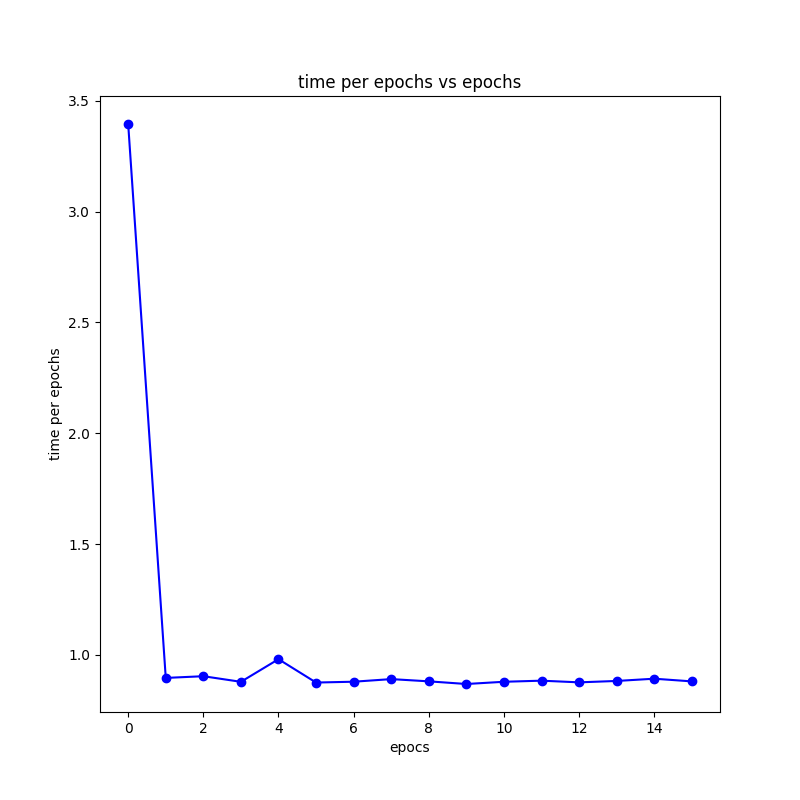

# Remark: 
**I am having a lot of trouble running the code—no GPU support on November 16(from the evening), so I could not run the code. But I run all those codes earlier. Perhaps today, I wanted a few nice graphs for the comparison and deleted previous figures, so I do not have any results. However, I am sure one can find the results as the code save all the required figures automatically. ** 

**If we run the code we will get the plot directly. **

# 2. mpirun -n 2 python tensorflow2_mnist_hvd.py

# 3. mpirun -n 4 python tensorflow2_mnist_hvd.py

# 4. mpirun -n 8 python tensorflow2_mnist_hvd.py

# Code: tensorflow2_mnist.py

In [ ]:
# Copyright 2019 Uber Technologies, Inc. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
import sys
import tensorflow as tf
import argparse
import numpy as np

import time

import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt

# test code
# print('can edit from here')
# sys.exit(0) 
t0 = time.time()
parser = argparse.ArgumentParser(description='TensorFlow MNIST Example')
parser.add_argument('--batch_size', type=int, default=256, metavar='N',
                    help='input batch size for training (default: 256)')
parser.add_argument('--epochs', type=int, default=16, metavar='N',
                    help='number of epochs to train (default: 16)')
parser.add_argument('--lr', type=float, default=0.01, metavar='LR',
                    help='learning rate (default: 0.01)')
parser.add_argument('--device', default='gpu',
                    help='Wheter this is running on cpu or gpu')
parser.add_argument('--num_inter', default=2, help='set number inter', type=int)
parser.add_argument('--num_intra', default=0, help='set number intra', type=int)

args = parser.parse_args()


if args.device == 'cpu':
    tf.config.threading.set_intra_op_parallelism_threads(args.num_intra)
    tf.config.threading.set_inter_op_parallelism_threads(args.num_inter)
else:
    gpus = tf.config.experimental.list_physical_devices('GPU')
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)



#---------------------------------------------------
# Dataset
#---------------------------------------------------
(mnist_images, mnist_labels), (x_test, y_test) = \
    tf.keras.datasets.mnist.load_data(path='mnist.npz')

dataset = tf.data.Dataset.from_tensor_slices(
    (tf.cast(mnist_images[..., tf.newaxis] / 255.0, tf.float32),
             tf.cast(mnist_labels, tf.int64))
)
test_dset = tf.data.Dataset.from_tensor_slices(
    (tf.cast(x_test[..., tf.newaxis] / 255.0, tf.float32),
             tf.cast(y_test, tf.int64))
)

nsamples = len(list(dataset))
ntests = len(list(test_dset))

# shuffle the dataset, with shuffle buffer to be 10000
dataset = dataset.repeat().shuffle(10000).batch(args.batch_size)
test_dset  = test_dset.repeat().batch(args.batch_size)

#----------------------------------------------------
# Model
#----------------------------------------------------
mnist_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, [3, 3], activation='relu'),
    tf.keras.layers.Conv2D(64, [3, 3], activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])
loss = tf.losses.SparseCategoricalCrossentropy()

opt = tf.optimizers.Adam(args.lr)

checkpoint_dir = './checkpoints/tf2_mnist'
checkpoint = tf.train.Checkpoint(model=mnist_model, optimizer=opt)

#------------------------------------------------------------------
# Training
#------------------------------------------------------------------
@tf.function
def training_step(images, labels):
    with tf.GradientTape() as tape:
        probs = mnist_model(images, training=True)
        loss_value = loss(labels, probs)
        pred = tf.math.argmax(probs, axis=1)
        equality = tf.math.equal(pred, labels)
        accuracy = tf.math.reduce_mean(tf.cast(equality, tf.float32))

    grads = tape.gradient(loss_value, mnist_model.trainable_variables)
    opt.apply_gradients(zip(grads, mnist_model.trainable_variables))
    return loss_value, accuracy

@tf.function
def validation_step(images, labels):
    probs = mnist_model(images, training=False)
    pred = tf.math.argmax(probs, axis=1)
    equality = tf.math.equal(pred, labels)
    accuracy = tf.math.reduce_mean(tf.cast(equality, tf.float32))
    loss_value = loss(labels, probs)
    return loss_value, accuracy

from tqdm import tqdm 
t0 = time.time()
nstep = nsamples//args.batch_size
ntest_step = ntests//args.batch_size
metrics={}
metrics['train_acc'] = []
metrics['valid_acc'] = []
metrics['train_loss'] = []
metrics['valid_loss'] = []
metrics['time_per_epochs'] = []
for ep in range(args.epochs):
    training_loss = 0.0
    training_acc = 0.0
    tt0 = time.time()
    for batch, (images, labels) in enumerate(dataset.take(nstep)):
        loss_value, acc = training_step(images, labels)
        training_loss += loss_value/nstep
        training_acc += acc/nstep
        if batch % 100 == 0: 
            checkpoint.save(checkpoint_dir)
            print('Epoch - %d, step #%06d/%06d\tLoss: %.6f' % (ep, batch, nstep, loss_value))
    # Testing
    test_acc = 0.0
    test_loss = 0.0
    for batch, (images, labels) in enumerate(test_dset.take(ntest_step)):
        loss_value, acc = validation_step(images, labels)
        test_acc += acc/ntest_step
        test_loss += loss_value/ntest_step
    tt1 = time.time()
    print('E[%d], train Loss: %.6f, training Acc: %.3f, val loss: %.3f, val Acc: %.3f\t Time: %.3f seconds' % (ep, training_loss, training_acc, test_loss, test_acc, tt1 - tt0))
    metrics['train_acc'].append(training_acc.numpy())
    metrics['train_loss'].append(training_loss.numpy())
    metrics['valid_acc'].append(test_acc.numpy())
    metrics['valid_loss'].append(test_loss.numpy())
    metrics['time_per_epochs'].append(tt1 - tt0) 

checkpoint.save(checkpoint_dir)
#create and save the images for comparison 

#usetex setting is particularly useful when you need LaTeX features. 

plt.rc('text', usetex=True)
plt.plot(range(args.epochs), metrics['train_acc'], 'r-o')
# naming the x axis
plt.xlabel('epocs')
# naming the y axis
plt.ylabel('train acc')
plt.title('train acc vs epochs')
plt.savefig("train_acc.png")
#plt.close()

plt.rc('text', usetex=True)
plt.figure(figsize=(8, 8))
plt.plot(range(args.epochs), metrics['train_loss'], 'b-')
# naming the x axis
plt.xlabel('epocs')
# naming the y axis
plt.ylabel('train loss')
plt.title('train loss vs epochs')
plt.savefig("train_loss.png")
plt.close()

plt.rc('text', usetex=True)
fig = plt.figure(figsize=(8, 8))
plt.plot(range(args.epochs), metrics['valid_acc'], 'ko')
# naming the x axis
plt.xlabel('epocs')
# naming the y axis
plt.ylabel('valid acc')
plt.title('valid acc vs epochs')
plt.savefig("valid_acc.png") # or you can pass a Figure object to pdf.savefig
plt.close()

plt.rc('text', usetex=False)
fig = plt.figure(figsize=(8, 8))
plt.plot(range(args.epochs), metrics['valid_loss'], 'ko')
# naming the x axis
plt.xlabel('epocs')
# naming the y axis
plt.ylabel('valid loss')
plt.title('valid_loss vs epochs')
plt.savefig("valid_loss.png") # or you can pass a Figure object to pdf.savefig
plt.close()

plt.rc('text', usetex=True)
plt.figure(figsize=(8, 8))
x = np.arange(0, 5, 0.1)
plt.plot(range(args.epochs), metrics['time_per_epochs'], 'b-')
# naming the x axis
plt.xlabel('epocs')
# naming the y axis
plt.ylabel('time per epochs')
plt.title('time per epochs vs epochs')
plt.savefig("time_per_epochs.png")
plt.close()
    

#plt.savefig("/home/haridasdas/results/train_accuray.png")

np.savetxt("metrics.dat", np.array([metrics['train_acc'], metrics['train_loss'], metrics['valid_acc'], metrics['valid_loss'], metrics['time_per_epochs']]).transpose())
t1 = time.time()
print("Total training time: %s seconds" %(t1 - t0))


# Remark: 
I am having a lot of trouble running the code—no GPU support on November 16 (from the evening), so I could not run the code. But I run all those codes earlier. Perhaps today, I wanted a few nice graphs for the comparison and deleted previous figures, so I do not have any results. However, I am sure one can find the results as the code save all the required figures automatically.  

# 1. mpirun -n 1 python tensorflow2_mnist_hvd.py

 # 2. mpirun -n 2 python tensorflow2_mnist_hvd.py

# 3. mpirun -n 4 python tensorflow2_mnist_hvd.py

# 4. mpirun -n 8 python tensorflow2_mnist_hvd.py